In [1]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-05-14 09:42:01--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  16.0MB/s    in 0.3s    

2024-05-14 09:42:01 (16.0 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv('bbc_text_cls.csv')

In [4]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
df['targets'] = df['labels'].astype("category").cat.codes

In [6]:
# number of classes
K = df['targets'].max() + 1
K

5

In [7]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [8]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 27856 unique tokens.


In [10]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (1557, 3483)


In [11]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3483)


In [12]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [13]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['targets'],
  epochs=50,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/50
49/49 [==============================] - 17s 282ms/step - loss: 1.5977 - accuracy: 0.2524 - val_loss: 1.5959 - val_accuracy: 0.3024
Epoch 2/50
49/49 [==============================] - 12s 245ms/step - loss: 1.5467 - accuracy: 0.3950 - val_loss: 1.4637 - val_accuracy: 0.4027
Epoch 3/50
49/49 [==============================] - 19s 374ms/step - loss: 1.3949 - accuracy: 0.4457 - val_loss: 1.2859 - val_accuracy: 0.4820
Epoch 4/50
49/49 [==============================] - 11s 212ms/step - loss: 1.1158 - accuracy: 0.4836 - val_loss: 0.9923 - val_accuracy: 0.5778
Epoch 5/50
49/49 [==============================] - 9s 189ms/step - loss: 0.9470 - accuracy: 0.6095 - val_loss: 1.0315 - val_accuracy: 0.5868
Epoch 6/50
49/49 [==============================] - 7s 150ms/step - loss: 0.8881 - accuracy: 0.7559 - val_loss: 0.8803 - val_accuracy: 0.8383
Epoch 7/50
49/49 [==============================] - 8s 159ms/step - loss: 0.7377 - accuracy: 0.8998 - val_loss: 0.7555 - val_a

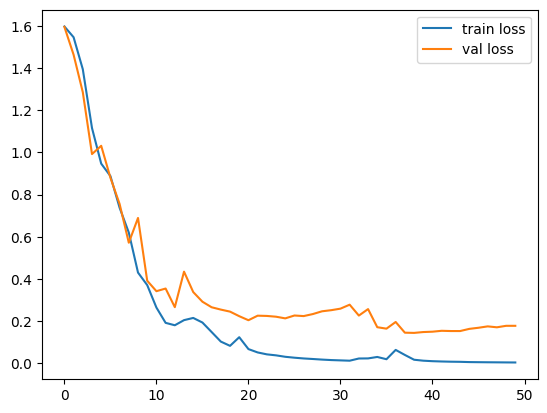

In [14]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

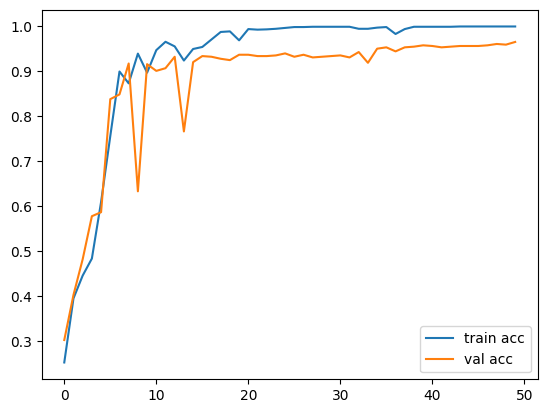

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();